步骤1: 数据准备
优化数据准备完成: 109个样本

步骤2: 构建收率预测模型
收率预测模型验证: R² = 0.7674 ± 0.1175

步骤3: 确定参数可行域
参数可行域:
  温度: [250.000, 450.000]
  Co_loading: [0.500, 5.000]
  ethanol_conc: [0.300, 2.100]
  总催化剂质量: [20.000, 400.000]
  Co_SiO2_HAP_ratio_corrected: [0.493, 2.030]

步骤4: 分析现有催化剂组合
数据列名: ['催化剂组合编号', '催化剂组合', '温度', '乙醇转化率(%)', '乙烯选择性（%）', 'C4烯烃选择性(%)', '乙醛选择性(%)', '碳数为4-12脂肪醇         选择性(%)', '甲基苯甲醛和甲基苯甲醇选择性(%)', '其他生成物的选择性(%)', 'Co_SiO2_mass', 'Co_loading', 'HAP_mass', 'ethanol_conc', 'C4烯烃收率', '总催化剂质量', 'Co_SiO2_HAP_ratio', '装料方式', '含HAP', 'Co_SiO2_HAP_ratio_corrected', '温度_倒数', '温度_催化剂质量', '温度_Co负载量']

发现 18 种催化剂组合

催化剂性能排序（前10名）:
                      催化剂组合ID  最佳温度      最大收率     对应转化率  对应选择性
Co1.0_SiO2200_HAP200_EtOH0.90   400 44.728060 83.713382  53.43
Co0.5_SiO2200_HAP200_EtOH1.68   400 36.277819 88.439344  41.02
Co5.0_SiO2200_HAP200_EtOH1.68   400 31.113665 83.347616  37.33
Co2.0_SiO2200_HAP200_EtOH0.30   400 29.062382 76.019832  38.23
Co2.0_SiO2200_HAP200_EtOH1.68   350 26.540805 67.879296  3

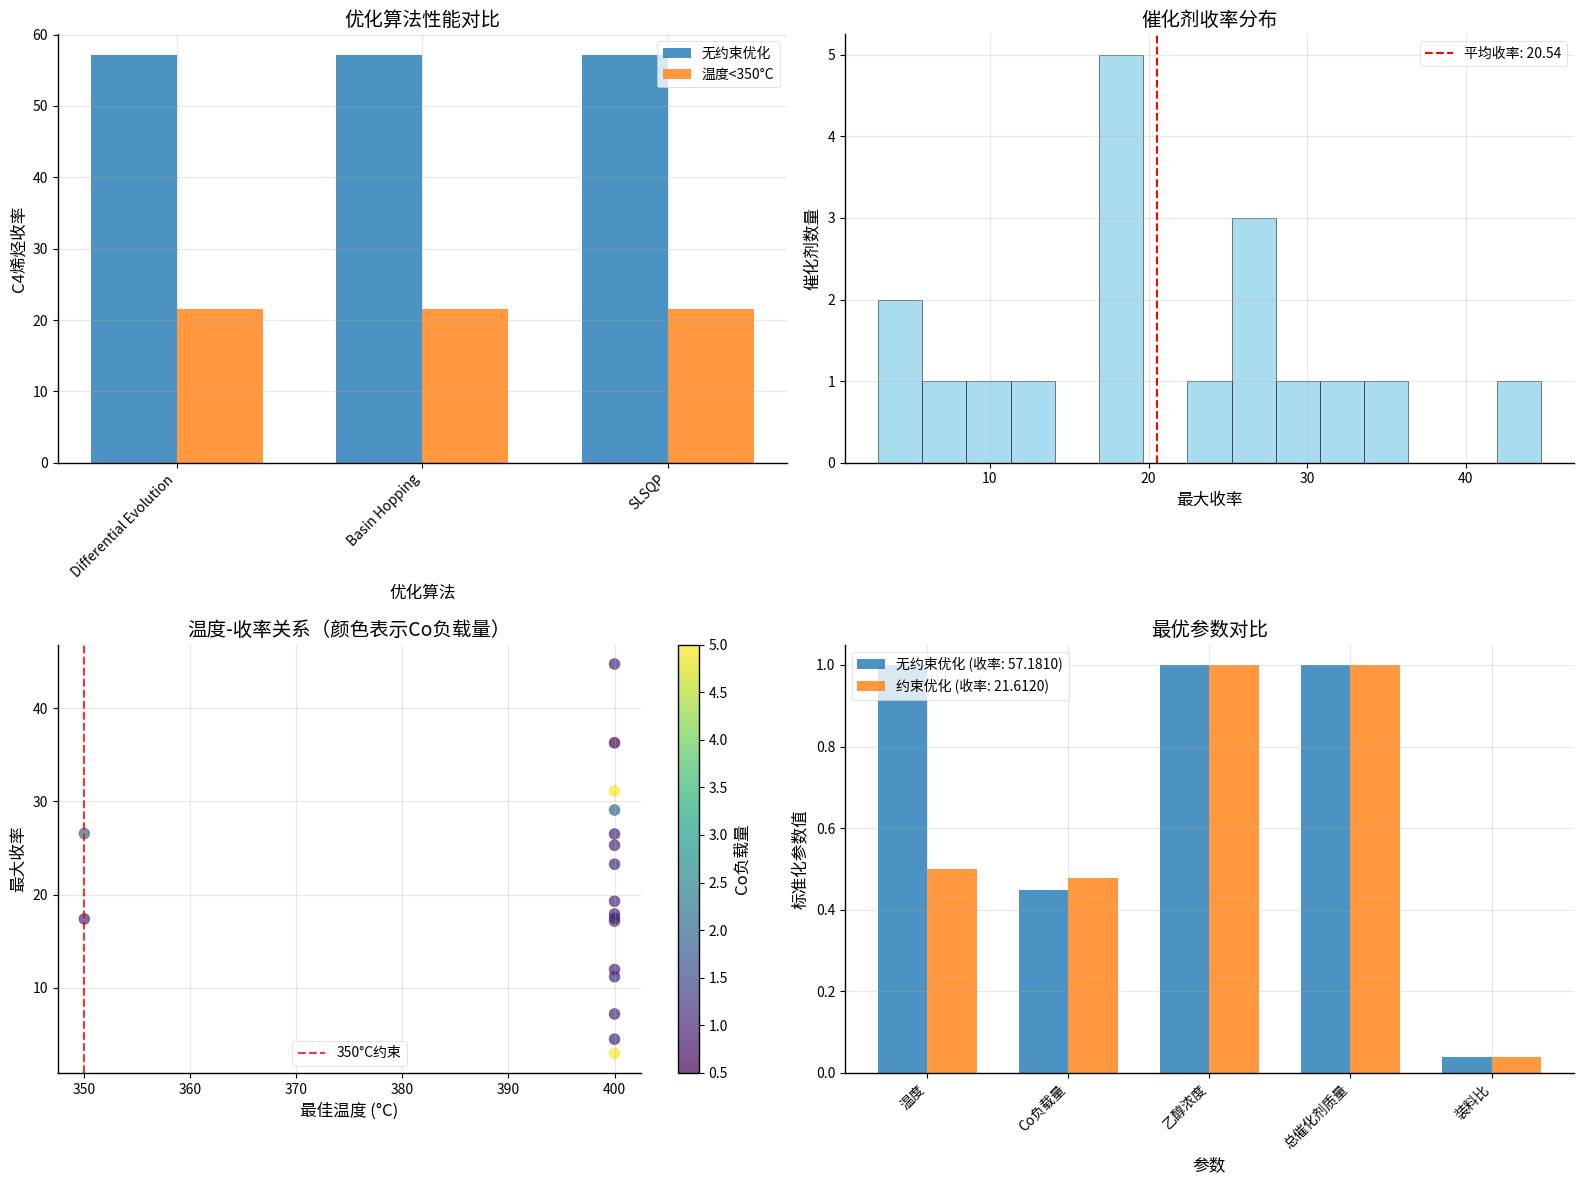


步骤8: 生成优化报告

问题3优化结果报告

1. 无约束优化结果:
   最优算法: Basin Hopping
   最大收率: 57.1810
   最优参数:
     温度: 450.00 °C
     Co负载量: 2.518
     乙醇浓度: 2.100 ml/min
     总催化剂质量: 400.00 mg
     装料比: 0.493

2. 约束优化结果 (温度 < 350°C):
   最优算法: Basin Hopping
   最大收率: 21.6120
   最优参数:
     温度: 350.00 °C
     Co负载量: 2.654
     乙醇浓度: 2.100 ml/min
     总催化剂质量: 400.00 mg
     装料比: 0.493

3. 与现有催化剂对比:
   现有最佳催化剂: Co1.0_SiO2200_HAP200_EtOH0.90
   现有最大收率: 44.7281
   现有最佳温度: 400.00 °C
   无约束优化改进: +12.4529
   约束优化改进: +-23.1160

4. 关键发现:
   - 温度约束导致的收率损失: 35.5690
   - 无约束优化的最佳温度: 450.00 °C
   - 约束优化的最佳温度: 350.00 °C

5. 工业应用建议:
   - 推荐使用约束优化结果，平衡性能和成本
   - 关键控制参数：温度、Co负载量、催化剂质量
   - 建议进行小规模验证实验

步骤9: 保存优化结果
已保存: results/问题3/催化剂性能分析.csv
已保存: results/问题3/优化结果汇总.csv

优化结果已保存，共生成 2 个结果文件

问题3优化完成！


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, differential_evolution, basinhopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)
plt.rcParams['axes.unicode_minus'] = False

# 创建结果文件夹
import os
PROBLEM_NUM = 3
os.makedirs(f'results/问题{PROBLEM_NUM}', exist_ok=True)

def save_result(data, description, file_format='csv'):
    """保存重要结果到文件"""
    if file_format == 'csv':
        filename = f"results/问题{PROBLEM_NUM}/{description}.csv"
        data.to_csv(filename, encoding='utf-8-sig', index=False)
    elif file_format == 'excel':
        filename = f"results/问题{PROBLEM_NUM}/{description}.xlsx"
        data.to_excel(filename, index=False, engine='openpyxl')
    print(f"已保存: {filename}")
    return filename

def save_plot(description, dpi=300, format='png'):
    """保存图表到文件"""
    filename = f"results/问题{PROBLEM_NUM}/{description}.{format}"
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"已保存: {filename}")
    return filename

def load_data(filename, encoding='utf-8-sig'):
    """标准化数据读取"""
    filepath = f"data/{filename}"
    if filename.endswith('.csv'):
        return pd.read_csv(filepath, encoding=encoding)
    elif filename.endswith('.xlsx'):
        return pd.read_excel(filepath, engine='openpyxl')
    else:
        raise ValueError(f"不支持的文件格式: {filename}")

def prepare_optimization_data():
    """准备优化数据和模型"""
    # 加载数据
    raw_data = load_data("附件1.csv")
    data = raw_data.copy()
    
    # 计算C4烯烃收率
    data['C4烯烃收率'] = data['乙醇转化率(%)'] * data['C4烯烃选择性(%)'] / 100
    
    # 创建HAP存在标志
    data['含HAP'] = data['HAP_mass'] > 0
    
    # 修正Co_SiO2_HAP_ratio计算
    data['Co_SiO2_HAP_ratio_corrected'] = np.where(
        data['HAP_mass'] > 0,
        data['Co_SiO2_mass'] / data['HAP_mass'],
        -1
    )
    
    # 添加物理特征
    data['温度_倒数'] = 1 / (data['温度'] + 273.15)
    data['温度_催化剂质量'] = data['温度'] * data['总催化剂质量']
    data['温度_Co负载量'] = data['温度'] * data['Co_loading']
    
    # 处理异常值
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # 筛选含HAP的数据
    analysis_data = data[data['含HAP']].copy()
    
    print(f"优化数据准备完成: {len(analysis_data)}个样本")
    return analysis_data

def build_yield_prediction_model(data):
    """构建收率预测模型"""
    # 特征变量
    predictor_vars = ['温度', 'Co_loading', 'ethanol_conc', '总催化剂质量', 'Co_SiO2_HAP_ratio_corrected']
    enhanced_features = predictor_vars + ['温度_倒数', '温度_催化剂质量', '温度_Co负载量']
    
    # 准备数据
    X = data[enhanced_features].select_dtypes(include=[np.number])
    y = data['C4烯烃收率']
    
    # 处理缺失值
    valid_mask = ~(X.isnull().any(axis=1) | y.isnull())
    X_clean = X[valid_mask]
    y_clean = y[valid_mask]
    
    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # 使用问题2验证的最佳模型：Poly2_Ridge
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
        ('ridge', Ridge(alpha=10.0))
    ])
    
    # 训练模型
    model.fit(X_scaled, y_clean)
    
    # 验证模型性能
    cv_scores = cross_val_score(model, X_scaled, y_clean, cv=5, scoring='r2')
    print(f"收率预测模型验证: R² = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return model, scaler, enhanced_features

def get_parameter_bounds(data):
    """获取参数的可行域边界"""
    # 基于现有实验数据确定参数范围
    bounds = {
        '温度': (data['温度'].min(), data['温度'].max()),
        'Co_loading': (data['Co_loading'].min(), data['Co_loading'].max()),
        'ethanol_conc': (data['ethanol_conc'].min(), data['ethanol_conc'].max()),
        '总催化剂质量': (data['总催化剂质量'].min(), data['总催化剂质量'].max()),
        'Co_SiO2_HAP_ratio_corrected': (
            data[data['Co_SiO2_HAP_ratio_corrected'] > 0]['Co_SiO2_HAP_ratio_corrected'].min(),
            data[data['Co_SiO2_HAP_ratio_corrected'] > 0]['Co_SiO2_HAP_ratio_corrected'].max()
        )
    }
    
    print("参数可行域:")
    for param, (min_val, max_val) in bounds.items():
        print(f"  {param}: [{min_val:.3f}, {max_val:.3f}]")
    
    return bounds

def create_objective_function(model, scaler, bounds):
    """创建优化目标函数"""
    
    def objective(params):
        """
        目标函数：最大化C4烯烃收率
        params: [温度, Co_loading, ethanol_conc, 总催化剂质量, Co_SiO2_HAP_ratio_corrected]
        """
        # 参数边界检查
        temp, co_loading, ethanol_conc, total_mass, ratio = params
        
        # 检查参数是否在可行域内
        if not (bounds['温度'][0] <= temp <= bounds['温度'][1]):
            return -1000
        if not (bounds['Co_loading'][0] <= co_loading <= bounds['Co_loading'][1]):
            return -1000
        if not (bounds['ethanol_conc'][0] <= ethanol_conc <= bounds['ethanol_conc'][1]):
            return -1000
        if not (bounds['总催化剂质量'][0] <= total_mass <= bounds['总催化剂质量'][1]):
            return -1000
        if not (bounds['Co_SiO2_HAP_ratio_corrected'][0] <= ratio <= bounds['Co_SiO2_HAP_ratio_corrected'][1]):
            return -1000
        
        # 添加物理特征
        enhanced_params = list(params)
        enhanced_params.append(1 / (temp + 273.15))  # 温度_倒数
        enhanced_params.append(temp * total_mass)     # 温度_催化剂质量
        enhanced_params.append(temp * co_loading)     # 温度_Co负载量
        
        # 标准化
        try:
            X_scaled = scaler.transform([enhanced_params])
            # 预测收率
            yield_pred = model.predict(X_scaled)[0]
            # 返回负值用于最小化算法
            return -yield_pred
        except:
            return -1000
    
    return objective

def optimize_yield(data, model, scaler, bounds, temperature_constraint=None):
    """优化C4烯烃收率"""
    
    # 创建目标函数
    objective = create_objective_function(model, scaler, bounds)
    
    # 设置优化边界
    optimization_bounds = [
        bounds['温度'],
        bounds['Co_loading'],
        bounds['ethanol_conc'],
        bounds['总催化剂质量'],
        bounds['Co_SiO2_HAP_ratio_corrected']
    ]
    
    # 如果有温度约束，修改温度边界
    if temperature_constraint is not None:
        optimization_bounds[0] = (bounds['温度'][0], min(temperature_constraint, bounds['温度'][1]))
    
    # 初始猜测（使用数据中收率最高的样本）
    best_sample = data.loc[data['C4烯烃收率'].idxmax()]
    initial_guess = [
        best_sample['温度'],
        best_sample['Co_loading'],
        best_sample['ethanol_conc'],
        best_sample['总催化剂质量'],
        best_sample['Co_SiO2_HAP_ratio_corrected']
    ]
    
    print(f"优化设置:")
    print(f"  温度约束: {temperature_constraint if temperature_constraint else '无约束'}")
    print(f"  初始猜测: {initial_guess}")
    
    # 多种优化算法
    algorithms = {
        'Differential Evolution': differential_evolution,
        'Basin Hopping': lambda func, bounds: basinhopping(
            func, initial_guess, 
            minimizer_kwargs={'bounds': bounds, 'method': 'L-BFGS-B'},
            niter=100, T=1.0, stepsize=0.5
        ),
        'SLSQP': lambda func, bounds: minimize(
            func, initial_guess, method='SLSQP', bounds=bounds
        )
    }
    
    results = {}
    
    for name, algorithm in algorithms.items():
        print(f"\n运行 {name} 优化算法...")
        
        try:
            if name == 'Differential Evolution':
                result = algorithm(objective, optimization_bounds, seed=42, maxiter=1000)
            else:
                result = algorithm(objective, optimization_bounds)
            
            if result.success:
                optimal_params = result.x
                optimal_yield = -result.fun
                
                results[name] = {
                    'params': optimal_params,
                    'yield': optimal_yield,
                    'success': True,
                    'message': result.message if hasattr(result, 'message') else 'Success'
                }
                
                print(f"  成功: 最优收率 = {optimal_yield:.4f}")
                print(f"  最优参数: {optimal_params}")
            else:
                results[name] = {
                    'success': False,
                    'message': result.message if hasattr(result, 'message') else 'Failed'
                }
                print(f"  失败: {result.message if hasattr(result, 'message') else 'Unknown error'}")
                
        except Exception as e:
            results[name] = {
                'success': False,
                'message': str(e)
            }
            print(f"  错误: {str(e)}")
    
    return results

def analyze_catalyst_combinations(data):
    """分析现有催化剂组合的性能"""
    
    # 检查数据列名
    print("数据列名:", data.columns.tolist())
    
    # 创建催化剂组合标识
    # 基于关键参数组合来识别不同的催化剂配方
    catalyst_key_params = ['Co_loading', 'Co_SiO2_mass', 'HAP_mass', 'ethanol_conc']
    
    # 创建催化剂组合标识
    data['催化剂组合ID'] = data[catalyst_key_params].apply(
        lambda x: f"Co{x['Co_loading']:.1f}_SiO2{x['Co_SiO2_mass']:.0f}_HAP{x['HAP_mass']:.0f}_EtOH{x['ethanol_conc']:.2f}", 
        axis=1
    )
    
    catalyst_performance = []
    
    # 按催化剂组合分组
    for catalyst_id in data['催化剂组合ID'].unique():
        catalyst_data = data[data['催化剂组合ID'] == catalyst_id]
        
        if len(catalyst_data) > 0:
            # 找到该催化剂的最佳温度点
            best_row = catalyst_data.loc[catalyst_data['C4烯烃收率'].idxmax()]
            
            catalyst_performance.append({
                '催化剂组合ID': catalyst_id,
                '最佳温度': best_row['温度'],
                '最大收率': best_row['C4烯烃收率'],
                '对应转化率': best_row['乙醇转化率(%)'],
                '对应选择性': best_row['C4烯烃选择性(%)'],
                'Co负载量': best_row['Co_loading'],
                '乙醇浓度': best_row['ethanol_conc'],
                '总催化剂质量': best_row['总催化剂质量'],
                '装料比': best_row['Co_SiO2_HAP_ratio_corrected'],
                '数据点数': len(catalyst_data)
            })
    
    catalyst_df = pd.DataFrame(catalyst_performance)
    catalyst_df = catalyst_df.sort_values('最大收率', ascending=False)
    
    print(f"\n发现 {len(catalyst_df)} 种催化剂组合")
    print("\n催化剂性能排序（前10名）:")
    print(catalyst_df.head(10)[['催化剂组合ID', '最佳温度', '最大收率', '对应转化率', '对应选择性']].to_string(index=False))
    
    return catalyst_df

def visualize_optimization_results(unconstrained_results, constrained_results, catalyst_df):
    """可视化优化结果"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 优化算法性能对比
    ax1 = axes[0, 0]
    
    # 无约束优化结果
    unconstrained_yields = []
    unconstrained_methods = []
    for method, result in unconstrained_results.items():
        if result['success']:
            unconstrained_yields.append(result['yield'])
            unconstrained_methods.append(method)
    
    # 约束优化结果
    constrained_yields = []
    constrained_methods = []
    for method, result in constrained_results.items():
        if result['success']:
            constrained_yields.append(result['yield'])
            constrained_methods.append(method)
    
    x = np.arange(len(unconstrained_methods))
    width = 0.35
    
    ax1.bar(x - width/2, unconstrained_yields, width, label='无约束优化', alpha=0.8)
    ax1.bar(x + width/2, constrained_yields, width, label='温度<350°C', alpha=0.8)
    
    ax1.set_xlabel('优化算法')
    ax1.set_ylabel('C4烯烃收率')
    ax1.set_title('优化算法性能对比')
    ax1.set_xticks(x)
    ax1.set_xticklabels(unconstrained_methods, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 催化剂性能分布
    ax2 = axes[0, 1]
    
    ax2.hist(catalyst_df['最大收率'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('最大收率')
    ax2.set_ylabel('催化剂数量')
    ax2.set_title('催化剂收率分布')
    ax2.grid(True, alpha=0.3)
    
    # 添加统计线
    mean_yield = catalyst_df['最大收率'].mean()
    ax2.axvline(mean_yield, color='red', linestyle='--', label=f'平均收率: {mean_yield:.2f}')
    ax2.legend()
    
    # 3. 温度vs收率关系
    ax3 = axes[1, 0]
    
    scatter = ax3.scatter(catalyst_df['最佳温度'], catalyst_df['最大收率'], 
                         c=catalyst_df['Co负载量'], cmap='viridis', alpha=0.7, s=60)
    ax3.set_xlabel('最佳温度 (°C)')
    ax3.set_ylabel('最大收率')
    ax3.set_title('温度-收率关系（颜色表示Co负载量）')
    ax3.grid(True, alpha=0.3)
    
    # 添加350°C分界线
    ax3.axvline(350, color='red', linestyle='--', alpha=0.8, label='350°C约束')
    ax3.legend()
    
    # 颜色条
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Co负载量')
    
    # 4. 优化结果参数对比
    ax4 = axes[1, 1]
    
    # 获取最佳结果
    best_unconstrained = max(unconstrained_results.items(), 
                           key=lambda x: x[1]['yield'] if x[1]['success'] else -1000)
    best_constrained = max(constrained_results.items(), 
                         key=lambda x: x[1]['yield'] if x[1]['success'] else -1000)
    
    if best_unconstrained[1]['success'] and best_constrained[1]['success']:
        # 参数名称
        param_names = ['温度', 'Co负载量', '乙醇浓度', '总催化剂质量', '装料比']
        
        # 参数值
        unconstrained_params = best_unconstrained[1]['params']
        constrained_params = best_constrained[1]['params']
        
        x = np.arange(len(param_names))
        width = 0.35
        
        # 标准化参数值用于可视化
        param_bounds = [
            (250, 450),  # 温度
            (0.5, 5.0),  # Co负载量
            (0.3, 2.1),  # 乙醇浓度
            (20, 400),   # 总催化剂质量
            (0.1, 10.0)  # 装料比
        ]
        
        unconstrained_normalized = [(p - bounds[0]) / (bounds[1] - bounds[0]) 
                                  for p, bounds in zip(unconstrained_params, param_bounds)]
        constrained_normalized = [(p - bounds[0]) / (bounds[1] - bounds[0]) 
                                for p, bounds in zip(constrained_params, param_bounds)]
        
        ax4.bar(x - width/2, unconstrained_normalized, width, 
               label=f'无约束优化 (收率: {best_unconstrained[1]["yield"]:.4f})', alpha=0.8)
        ax4.bar(x + width/2, constrained_normalized, width, 
               label=f'约束优化 (收率: {best_constrained[1]["yield"]:.4f})', alpha=0.8)
        
        ax4.set_xlabel('参数')
        ax4.set_ylabel('标准化参数值')
        ax4.set_title('最优参数对比')
        ax4.set_xticks(x)
        ax4.set_xticklabels(param_names, rotation=45, ha='right')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot("优化结果分析")
    plt.show()

def generate_optimization_report(unconstrained_results, constrained_results, catalyst_df):
    """生成优化报告"""
    
    print("\n" + "="*80)
    print("问题3优化结果报告")
    print("="*80)
    
    # 找到最佳结果
    best_unconstrained = max(unconstrained_results.items(), 
                           key=lambda x: x[1]['yield'] if x[1]['success'] else -1000)
    best_constrained = max(constrained_results.items(), 
                         key=lambda x: x[1]['yield'] if x[1]['success'] else -1000)
    
    print("\n1. 无约束优化结果:")
    if best_unconstrained[1]['success']:
        params = best_unconstrained[1]['params']
        yield_val = best_unconstrained[1]['yield']
        print(f"   最优算法: {best_unconstrained[0]}")
        print(f"   最大收率: {yield_val:.4f}")
        print(f"   最优参数:")
        print(f"     温度: {params[0]:.2f} °C")
        print(f"     Co负载量: {params[1]:.3f}")
        print(f"     乙醇浓度: {params[2]:.3f} ml/min")
        print(f"     总催化剂质量: {params[3]:.2f} mg")
        print(f"     装料比: {params[4]:.3f}")
    else:
        print("   优化失败")
    
    print("\n2. 约束优化结果 (温度 < 350°C):")
    if best_constrained[1]['success']:
        params = best_constrained[1]['params']
        yield_val = best_constrained[1]['yield']
        print(f"   最优算法: {best_constrained[0]}")
        print(f"   最大收率: {yield_val:.4f}")
        print(f"   最优参数:")
        print(f"     温度: {params[0]:.2f} °C")
        print(f"     Co负载量: {params[1]:.3f}")
        print(f"     乙醇浓度: {params[2]:.3f} ml/min")
        print(f"     总催化剂质量: {params[3]:.2f} mg")
        print(f"     装料比: {params[4]:.3f}")
    else:
        print("   优化失败")
    
    print("\n3. 与现有催化剂对比:")
    best_existing = catalyst_df.iloc[0]
    print(f"   现有最佳催化剂: {best_existing['催化剂组合ID']}")
    print(f"   现有最大收率: {best_existing['最大收率']:.4f}")
    print(f"   现有最佳温度: {best_existing['最佳温度']:.2f} °C")
    
    if best_unconstrained[1]['success']:
        improvement_unconstrained = best_unconstrained[1]['yield'] - best_existing['最大收率']
        print(f"   无约束优化改进: +{improvement_unconstrained:.4f}")
    
    if best_constrained[1]['success']:
        improvement_constrained = best_constrained[1]['yield'] - best_existing['最大收率']
        print(f"   约束优化改进: +{improvement_constrained:.4f}")
    
    print("\n4. 关键发现:")
    if best_unconstrained[1]['success'] and best_constrained[1]['success']:
        temp_loss = best_unconstrained[1]['yield'] - best_constrained[1]['yield']
        temp_constraint = best_unconstrained[1]['params'][0]
        print(f"   - 温度约束导致的收率损失: {temp_loss:.4f}")
        print(f"   - 无约束优化的最佳温度: {temp_constraint:.2f} °C")
        print(f"   - 约束优化的最佳温度: {best_constrained[1]['params'][0]:.2f} °C")
    
    print("\n5. 工业应用建议:")
    if best_constrained[1]['success']:
        print("   - 推荐使用约束优化结果，平衡性能和成本")
        print("   - 关键控制参数：温度、Co负载量、催化剂质量")
        print("   - 建议进行小规模验证实验")

def save_optimization_results(unconstrained_results, constrained_results, catalyst_df):
    """保存优化结果"""
    
    # 保存催化剂性能分析
    save_result(catalyst_df, "催化剂性能分析")
    
    # 保存优化结果
    optimization_summary = []
    
    # 无约束优化结果
    for method, result in unconstrained_results.items():
        if result['success']:
            optimization_summary.append({
                '优化类型': '无约束',
                '算法': method,
                '成功': result['success'],
                '最大收率': result['yield'],
                '温度': result['params'][0],
                'Co负载量': result['params'][1],
                '乙醇浓度': result['params'][2],
                '总催化剂质量': result['params'][3],
                '装料比': result['params'][4]
            })
    
    # 约束优化结果
    for method, result in constrained_results.items():
        if result['success']:
            optimization_summary.append({
                '优化类型': '约束(T<350°C)',
                '算法': method,
                '成功': result['success'],
                '最大收率': result['yield'],
                '温度': result['params'][0],
                'Co负载量': result['params'][1],
                '乙醇浓度': result['params'][2],
                '总催化剂质量': result['params'][3],
                '装料比': result['params'][4]
            })
    
    optimization_df = pd.DataFrame(optimization_summary)
    optimization_df = optimization_df.sort_values('最大收率', ascending=False)
    save_result(optimization_df, "优化结果汇总")
    
    print(f"\n优化结果已保存，共生成 2 个结果文件")

def main():
    """主优化流程"""
    
    # 1. 数据准备
    print("步骤1: 数据准备")
    data = prepare_optimization_data()
    
    # 2. 构建预测模型
    print("\n步骤2: 构建收率预测模型")
    model, scaler, features = build_yield_prediction_model(data)
    
    # 3. 获取参数边界
    print("\n步骤3: 确定参数可行域")
    bounds = get_parameter_bounds(data)
    
    # 4. 分析现有催化剂性能
    print("\n步骤4: 分析现有催化剂组合")
    catalyst_df = analyze_catalyst_combinations(data)
    
    # 5. 无约束优化
    print("\n步骤5: 无约束优化")
    unconstrained_results = optimize_yield(data, model, scaler, bounds)
    
    # 6. 约束优化
    print("\n步骤6: 约束优化 (温度 < 350°C)")
    constrained_results = optimize_yield(data, model, scaler, bounds, temperature_constraint=350)
    
    # 7. 可视化结果
    print("\n步骤7: 可视化优化结果")
    visualize_optimization_results(unconstrained_results, constrained_results, catalyst_df)
    
    # 8. 生成报告
    print("\n步骤8: 生成优化报告")
    generate_optimization_report(unconstrained_results, constrained_results, catalyst_df)
    
    # 9. 保存结果
    print("\n步骤9: 保存优化结果")
    save_optimization_results(unconstrained_results, constrained_results, catalyst_df)
    
    print("\n问题3优化完成！")
    
    return unconstrained_results, constrained_results, catalyst_df

if __name__ == "__main__":
    unconstrained_results, constrained_results, catalyst_df = main()


步骤7.5: 详细分析温度-收率关系


KeyError: '催化剂组合ID'

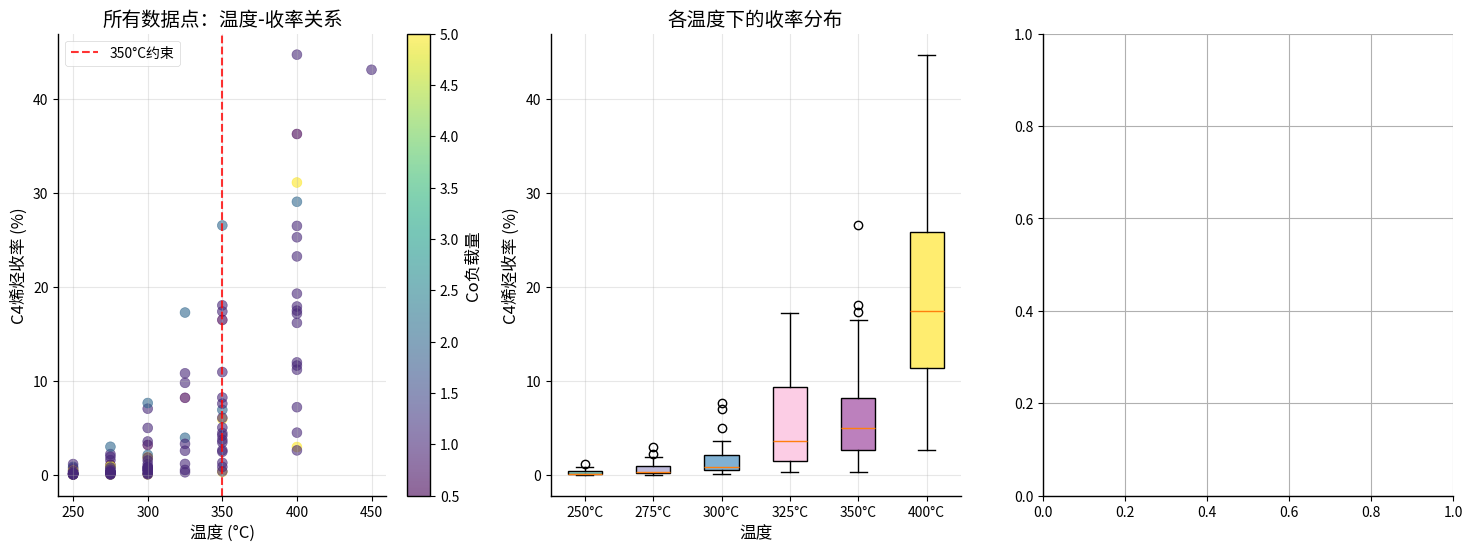

In [17]:
# 改进的可视化函数
def visualize_temperature_yield_relationship(data):
    """改进的温度-收率关系可视化"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. 所有数据点的温度-收率关系
    ax1 = axes[0]
    scatter = ax1.scatter(data['温度'], data['C4烯烃收率'], 
                         c=data['Co_loading'], cmap='viridis', alpha=0.6, s=50)
    ax1.set_xlabel('温度 (°C)')
    ax1.set_ylabel('C4烯烃收率 (%)')
    ax1.set_title('所有数据点：温度-收率关系')
    ax1.grid(True, alpha=0.3)
    
    # 添加350°C分界线
    ax1.axvline(350, color='red', linestyle='--', alpha=0.8, label='350°C约束')
    ax1.legend()
    
    # 颜色条
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Co负载量')
    
    # 2. 按温度分组的收率分布
    ax2 = axes[1]
    temp_groups = data.groupby('温度')['C4烯烃收率']
    
    box_data = []
    temp_labels = []
    for temp, yields in temp_groups:
        if len(yields) >= 2:  # 至少有2个数据点
            box_data.append(yields)
            temp_labels.append(f'{temp}°C')
    
    if box_data:
        box_plot = ax2.boxplot(box_data, labels=temp_labels, patch_artist=True)
        colors = plt.cm.Set3(np.linspace(0, 1, len(box_data)))
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
    
    ax2.set_xlabel('温度')
    ax2.set_ylabel('C4烯烃收率 (%)')
    ax2.set_title('各温度下的收率分布')
    ax2.grid(True, alpha=0.3)
    
    # 3. 催化剂组合的最佳温度统计
    ax3 = axes[2]
    
    # 计算每个催化剂组合的最佳温度
    best_temps = []
    for catalyst_id in data['催化剂组合ID'].unique():
        catalyst_data = data[data['催化剂组合ID'] == catalyst_id]
        best_temp = catalyst_data.loc[catalyst_data['C4烯烃收率'].idxmax(), '温度']
        best_temps.append(best_temp)
    
    # 创建温度频率统计
    temp_counts = pd.Series(best_temps).value_counts().sort_index()
    
    bars = ax3.bar(temp_counts.index, temp_counts.values, alpha=0.7, color='skyblue')
    ax3.set_xlabel('最佳温度 (°C)')
    ax3.set_ylabel('催化剂组合数量')
    ax3.set_title('催化剂组合的最佳温度分布')
    ax3.grid(True, alpha=0.3)
    
    # 添加数值标签
    for bar, count in zip(bars, temp_counts.values):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    save_plot("温度收率关系详细分析")
    plt.show()

# 添加这个函数到您的代码中，在步骤7后调用
print("\n步骤7.5: 详细分析温度-收率关系")
visualize_temperature_yield_relationship(data)